In [1]:
!pip install --upgrade git+https://github.com/roshan-pandey/Semantic-Segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/roshan-pandey/Semantic-Segmentation to /tmp/pip-req-build-7flq1lx4
  Running command git clone -q https://github.com/roshan-pandey/Semantic-Segmentation /tmp/pip-req-build-7flq1lx4
ERROR: File "setup.py" not found for legacy project git+https://github.com/roshan-pandey/Semantic-Segmentation.


In [2]:
!pip install patchify
!pip install keras
!pip install tensorflow
!pip install opencv-python
!pip install keras-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 7.5 MB/s 
     |████████████████████████████████| 753 kB 44.2 MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=29071 sha256=9b792f4f27b60278b5bbd012db0a9e1f01063aaf0c81751962df3c825c70032e
  Stored in directory: /root/.cache/pip/wheels/68/dc/b3/596a3e2461ba16e935ef31661c26e823f841cfb577cec4c47a
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imagei

In [3]:
!pip install segmentation_models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.1 MB/s 


In [4]:
!pip install --upgrade git+https://github.com/keras-team/keras.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-yvlg4m7z
  Running command git clone -q https://github.com/keras-team/keras.git /tmp/pip-req-build-yvlg4m7z
ERROR: File "setup.py" not found for legacy project git+https://github.com/keras-team/keras.git.


In [5]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

Segmentation Models: using `keras` framework.


In [6]:
sm.set_framework('tf.keras')

# Data Loading

In [7]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [8]:
# loading image data...
def data_loader(folder_dir):
    #  folder_dir = "/content/gdrive/MyDrive/Project/dataset/Images"
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [9]:
image_dataset = data_loader("/content/gdrive/MyDrive/Project/dataset/Images") # real images...

In [10]:
mask_dataset = data_loader("/content/gdrive/MyDrive/Project/dataset/Annotations") # masked images...

In [11]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [12]:
mask_dataset.shape

(136, 128, 128, 3)

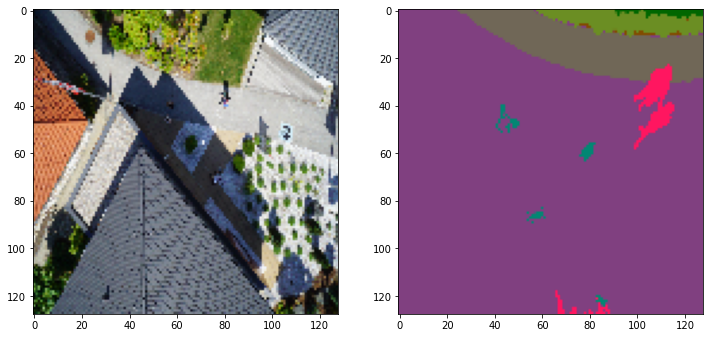

In [13]:
# Sanity check...
image_number = random.randint(0, len(mask_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [14]:
mask_labels = pd.read_csv('/content/gdrive/MyDrive/Project/class_dict.csv') # mask labels RGB values...

In [15]:
mask_labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [16]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

In [18]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3) # adding channel dim...

Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


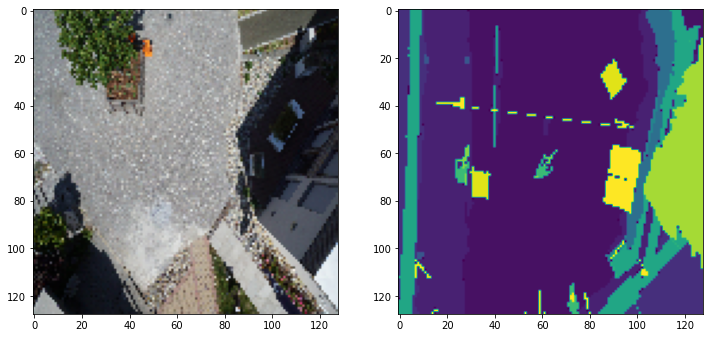

In [19]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [20]:
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes = n_classes) # one hot encoding the labels...

In [21]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

In [22]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34' 
preprocess_input = sm.get_preprocessing(BACKBONE)

In [23]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

In [24]:
# define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

85532672/85521592 [==============================] - 1s 0us/step


In [25]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [26]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [27]:
# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/100
7/7 [==============================] - 51s 7s/step - loss: 3.1088 - accuracy: 0.0509 - val_loss: 20.9423 - val_accuracy: 0.2222
Epoch 2/100
7/7 [==============================] - 38s 5s/step - loss: 2.6837 - accuracy: 0.2271 - val_loss: 71.5671 - val_accuracy: 0.2743
Epoch 3/100
7/7 [==============================] - 38s 5s/step - loss: 2.3444 - accuracy: 0.3617 - val_loss: 245.0465 - val_accuracy: 0.3247
Epoch 4/100
7/7 [==============================] - 40s 6s/step - loss: 2.1387 - accuracy: 0.4120 - val_loss: 898.8779 - val_accuracy: 0.3299
Epoch 5/100
7/7 [==============================] - 38s 5s/step - loss: 2.0499 - accuracy: 0.4188 - val_loss: 45.1988 - val_accuracy: 0.3319
Epoch 6/100
7/7 [==============================] - 38s 5s/step - loss: 2.0119 - accuracy: 0.4399 - val_loss: 101.5100 - val_accuracy: 0.3322
Epoch 7/100
7/7 [==============================] - 38s 5s/step - loss: 1.9869 - accuracy: 0.4329 - val_loss: 227.3818 - val_accuracy: 0.3306
Epoch 8/100
7/7 

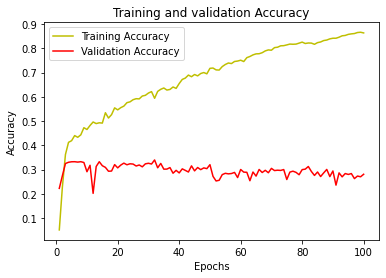

In [28]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
model_resnet_backbone.save('../models/resnet_backbone.hdf5')

In [30]:
model = load_model('../models/resnet_backbone.hdf5') # loading model...

In [31]:
# making predictions...
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

In [32]:
# randomly selecting an image from the test set and making prediction...
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

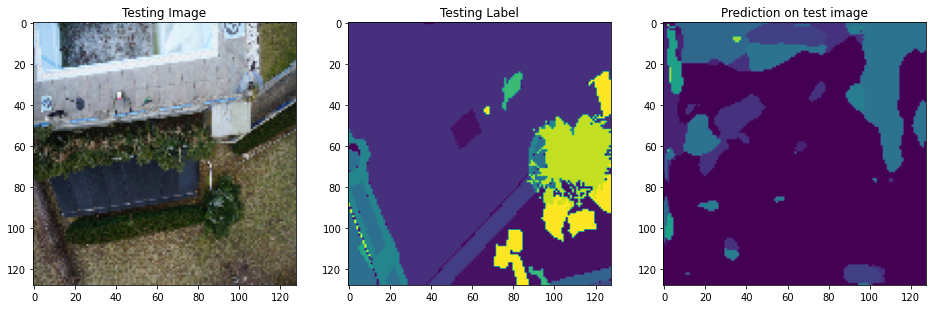

In [33]:
# plotting the real image, test labeled image and predicted labeled image...
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()